# Swin Transformer

「シフトウィンドウ（Shifted windows）」 を用いて表現を計算する、階層型トランスフォーマー を提案  

計算量の削減: 通常のTransformerは画像が大きくなると計算量が爆発しますが、Swinは「窓（ウィンドウ）」の中で計算するため、大きな画像も扱いやすくなっています。

精度の向上: 最初の質問にあった「セグメンテーション（領域抽出）」のような精密なタスクにおいて、この階層構造が高い効果を発揮します。

汎用性: 分類だけでなく、物体検出やセグメンテーションなど、あらゆる画像処理の「土台（バックボーン）」として使える点が画期的です。  

- 特長  
（Swin Transformer、ViT）  
- 特長マップ  
(階層的、変化なし)  
- 計算範囲  
(ローカルウィンド内、画像全体)  
- 計算コスト  
(画像サイズに比例つまり線形、二次関数的に増加)
- 可能  
(物体検出やセグメンテーション、画像分類)

#### ViTについて  
ViTは画像を**「パッチ」**と呼ばれる正方形の断片（例：16x16ピクセル）に分割します。このパッチを単語のように並べて「一文」として扱い、Transformerに入力  
最初から画像全体のパッチ（単語）同士の関係を一気に計算（Global Self-Attention）できる。これにより、画像内の離れた場所にある物体同士の関係性を捉えられる。  
- 弱点：計算コストが高い。画像全体を一気に計算するから。高解像度に向かない。  
細かいものが苦手。パッチの大きさを扱うためそれよりも小さいものを検出したり境界線を引くセグメンテーションには不向き。  

処理は重いけど画像全体を理解できるViTに対して、窓をずらしながら効率よく、細部までみられるようにしたい。-> swin transformer

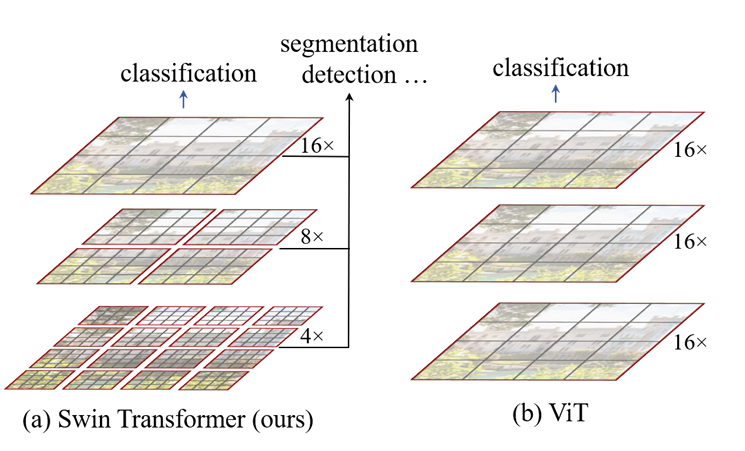

In [3]:
from PIL import Image
data = 'st1.png'
img = Image.open(data)
img

データ内の長距離の依存関係をモデル化するために「アテンション（注意機構）」を利用している点が大きな特徴  

- 階層的な特長マップとは  
Swin Transformerは、小さいサイズのパッチ（灰色で示された枠）から始まり、層が深くなるにつれて隣接するパッチを徐々に統合していくことで、階層的な表現を構築します。この階層的な特徴マップにより、Swin Transformerモデルは、FPN（Feature Pyramid Networks）やU-Netといった、高密度予測のための高度な手法を容易に活用できるようになります。  

- 線形な計算量  
画像を分割した重なりのないウィンドウ（赤色で示された枠）内で、局所的に自己注意を計算することで実現されます。各ウィンドウ内のパッチ数は固定されているため、計算複雑度は画像サイズに比例（線形）することになります。
    - 自己注意  
    データ内のどこに注目するか。（多分重みか？）パーツごとの関係性を把握する。CNNでは近くのピクセル同士の関係しか見れなかった。  
- ウィンドウ内で計算が完結する。つまり、画像サイズが増加（高解像度）となってもウィンドウ内での計算量は変わらない。（全体の身を見た場合、解像度が2倍になると計算量は16倍になるらしい。ウィンドウ内で区切ると計算量は4倍程度）

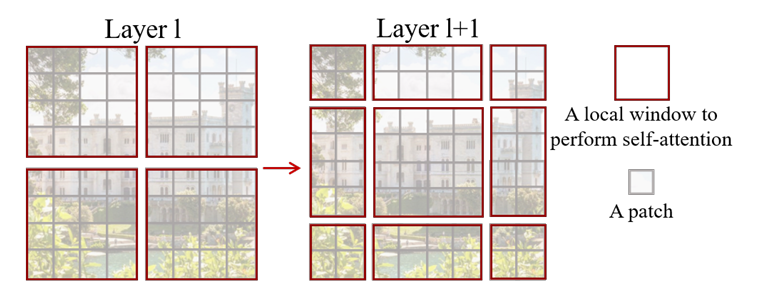

In [4]:
data = 'st2.png'
img = Image.open(data)
img

層 $l$（左図）では、通常のウィンドウ分割方式が採用され、各ウィンドウ内で自己注意が計算されます。続く層 $l+1$（右図）では、ウィンドウの分割位置がシフト（配置をずらす）され、新しいウィンドウが生成されます。この新しいウィンドウにおける自己注意の計算は、前の層 $l$ におけるウィンドウの境界を跨いで行われるため、ウィンドウ間での情報の繋がりが提供されます。

**自己注意（Self-attention）層の間でウィンドウの区切りをずらす（シフトさせる）**  

層が重なるごとに窓の位置を「半分のサイズ」だけ斜めにずらします.  
計算コストを低く抑えたまま（窓の中だけで計算する仕組みは維持したまま）、画像全体の情報を網羅的に伝えることができる.  
スライディングウィンドウ（窓を1ピクセルずつ細かく動かす方法）」は、計算が非常に複雑で時間がかかる。 Swinでは、効率的にやれる。  

#### 指標の知識

- mIoU (mean Intersection over Union): セマンティック・セグメンテーションの精度指標です。「AIが予測した範囲」と「実際の正解範囲」がどれだけ重なっているかを0〜1で表します。  
- mask AP (Average Precision): 物体を検出し、その形をなぞる（マスクを作る）精度の指標です。

ViTは、高密度なビジョンタスク（物体検出やセグメンテーションなど）や、入力画像が高解像度な場合には汎用バックボーンとして適していません。なぜなら、生成される特徴マップの解像度が低く、計算量が画像サイズの2乗で増加するためです。  

## 手法

#### 全体構造

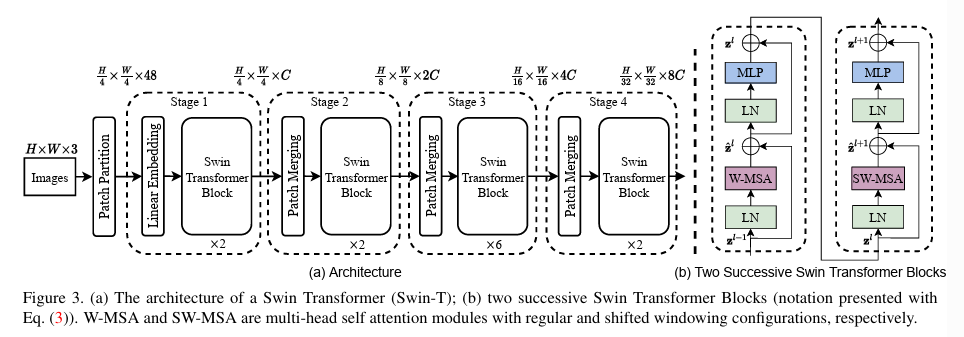

In [5]:
Image.open('st3.png')

- patch partition  

入力されたRGB画像をパッチで分割する。これはトークンとして扱われる。
サイズは4×4。つまり、各パッチの特徴次元数は4×4×3の48となる。

**ステージ1**
- Linear Embedding（全結合層と同じようなもの）  
画像の高次元のデータを後の層であるトランスフォーマーが扱えるように1本のベクトルとする。  
1. 切り出し: 画像を $4 \times 4$ ピクセルのパッチに切り出す（合計48個の数値）。
2. 平坦化（Flatten）: 48個の数値を1列に並べる。
3. 線形変換（ここが埋め込み）: 48個の数値に「重み行列」を掛け算し、次元数 $C$（例えば96個の数値）に変換する。

- swin transformer block  
線形にしたことでそのパッチ内の関連性について学習した。そのウィンドをずらすことでパッチ間の関係性について計算できる。  
    - W-MSA (Window Multi-head Self-Attention):ウィンド内の関係性
    - SW-MSA (Shifted Window Multi-head Self-Attention):ウィンド間の関係性  

画像のトークン数はブロックを通る前と同じ(H\4 * W\4)  

**ステージ2**  
- Patch Merging  
トークン数が削減。隣接する2*2の各パッチグループの特徴量を連結し、その連結した特徴量に対して線形層を適用する。  
トークンの数は1/2 * 1/2 = 1/4倍に減少？
- Linear Embedding  
線形化し、次元数が2Cになる。
- swin transformer block  
再度関係性を計算する。  

**ステージ3, 4**  
解像度は $\frac{H}{32} \times \frac{W}{32}$、次元数は $8C$。






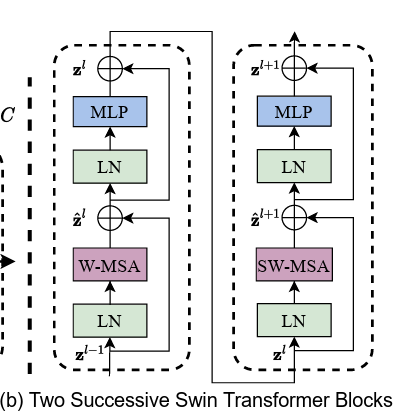

In [6]:
Image.open('st4.png')

窓を固定して計算する層（左図）と窓をずらして計算する層（右側）がペアになっている。

では、窓の中で特徴量を計算し、窓の外と関係性について計算した場合、その計算量は画像の内のパッチ数がNの場合、N * NでN^2の計算量となって膨大になる。  
これを解決するために画像内だけの計算量に抑えたい。そうした場合、計算量は以下のように変化する。  

$$\Omega(\text{MSA}) = 4hwC^2 + 2(hw)^2C \quad (1)$$

$$\Omega(\text{W-MSA}) = 4hwC^2 + 2M^2hwC \quad (2)$$

重なりが無いように均等に分割する。h = high, w = weigh,  M * M = ウィンド内にあるパッチ数  
ウィンド外を含めて計算した場合、解像度の変化によって2次関数的に計算量が増えますが、窓内では計算量は線形です。  

窓内に計算をとどめた場合、窓間の関係性を見つけることができない。それを解決するためにシフトウィンドウ分割を行う。

- シフトウィンドウ分割  
シフトの量: $(M/2, M/2)$  
窓のサイズが $4 \times 4$ なら、右と下に 2 ピクセルずつずらします。これにより、第1レイヤーでの「窓の角」が、第2レイヤーでは「窓の中心」付近に来ることになります  
残差の計算はよくわからないのでパス。後でやる  

$$\hat{z}^l = \text{W-MSA}(\text{LN}(z^{l-1})) + z^{l-1}$$
$$z^l = \text{MLP}(\text{LN}(\hat{z}^l)) + \hat{z}^l$$
$$\hat{z}^{l+1} = \text{SW-MSA}(\text{LN}(z^l)) + z^l$$
$$z^{l+1} = \text{MLP}(\text{LN}(\hat{z}^{l+1})) + \hat{z}^{l+1} \quad (3)$$

### ではシフトしていて端の余ったとこはどう対処しますか

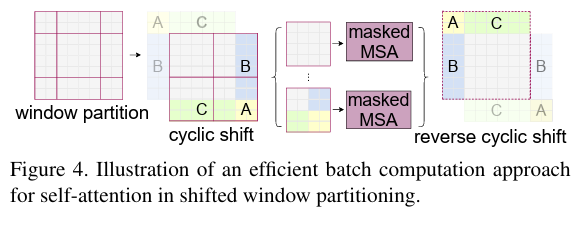

In [7]:
Image.open('st5.png')

単純にパディングすると計算量が2.25倍になってしまう。  
- 循環シフト  
はみ出した部分を切り取って、反対側の端に張り付ける。窓の総数が変わらず、M*Mが保たれるので計算量の増加なし  

でも、反対側につけた画像の位置家計に関する情報はおかしいことになるのでは？  

- マスキング  
同じ窓の中にいても、もともと遠く離れていたパッチ同士は計算結果を無視する（マスクする）」という処理を加える。

## ？

$$\text{Attention}(Q, K, V) = \text{SoftMax}\left(\frac{QK^T}{\sqrt{d}} + B\right)V \quad (4)$$

## 結論

階層的な特徴表現を生成し、入力画像サイズに対して線形な計算複雑性を持つ新しいビジョン・トランスフォーマー　「Swin Transformer」